### Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as ps 
from tqdm import tqdm
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import matplotlib as mpl
import matplotlib.pyplot as plt
from svcviz.viz_gwr import viz_gwr, viz_gw, compare_conf, compare_two_surf, threePanel
from svcviz.utils import shift_colormap, truncate_colormap
import warnings
warnings.filterwarnings('ignore')

#### Preprocessing

- Load the datasets into pandas and geopandas dataframes

In [2]:
df = pd.read_csv("data/countypres_2000-2020.csv")
df2 = pd.read_csv("data/voting_2020.csv")[["county_id","pct_black", "total_pop", 
                                                "pct_hisp", "median_income",
                                               "pct_65_over", "pct_age_18_29", 
                                                "pct_fb", "sex_ratio", "ln_pop_den",
                                               "pct_bach", "pct_uninsured", "median_income"]]

dfgp  = pd.read_csv("data/ggp-us-dfii.csv").drop('delete', axis=1)

df3 = dfgp[['id', 'se0', 'b0', 'Intercept','sepct_black',
       'bpct_black', 'sepct_hisp', 'bpct_hisp', 'sepct_65_over', 'bpct_65_over', 'sepct_age_18_29',
       'bpct_age_18_29', 'sepct_fb', 'bpct_fb', 'sepct_uninsured',
       'bpct_uninsured', 'sepct_bach', 'bpct_bach', 'seln_pop_den',
       'bln_pop_den']]

- Get 2020 U.S election data + democrat party and exclude D.C, Hawaii, and Alaska
- create a geometry attribute from GeoJSON file 
- Set the CRS
- visualize the counties in the U.S

In [3]:
df = df[(df.year==2020) & (df.party=='DEMOCRAT') & (df.state!='DISTRICT OF COLUMBIA')] 

In [4]:
df = df[["state", "county_name", "county_fips","party", "totalvotes", "mode"]]

In [5]:
df3.head(2)

,id,se0,b0,Intercept,sepct_black,bpct_black,sepct_hisp,bpct_hisp,sepct_65_over,bpct_65_over,sepct_age_18_29,bpct_age_18_29,sepct_fb,bpct_fb,sepct_uninsured,bpct_uninsured,sepct_bach,bpct_bach,seln_pop_den,bln_pop_den
0,1001,0.109232,-0.161032,1,0.036349,0.046597,0.283512,-0.126066,0.070951,0.043623,0.052382,-0.056577,0.155654,0.188183,0.026215,0.031122,0.064936,0.099549,0.097896,0.278338
1,1003,0.136123,-0.102484,1,0.053384,0.012584,0.344177,-0.064931,0.088085,0.087716,0.080351,-0.025321,0.201540,0.212545,0.030258,0.040352,0.083381,0.062685,0.113054,0.310424


In [6]:
newdf = df.merge(df2, left_on='county_fips', right_on='county_id', how='right')

In [7]:
newdf = newdf[(newdf['mode']=='TOTAL') | (newdf['mode']=='ELECTION DAY')]

In [8]:
counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
                                                                            .sort_values(by='id').reset_index(drop=True)

empty = counties['geometry'].is_empty
counties_non_empty = counties[~empty].copy()

counties_non_empty['lon'] = counties_non_empty['geometry'].centroid.x
counties_non_empty['lat'] = counties_non_empty['geometry'].centroid.y
counties_non_empty['id'] = counties_non_empty['id'].astype('int')

In [9]:
data = counties_non_empty.merge(newdf, left_on='id', right_on='county_fips')

In [10]:
data = data[data.state!='HAWAII']

In [11]:
data.set_crs(epsg=4269, allow_override=True, inplace=True)
data = data.to_crs(epsg=4269)

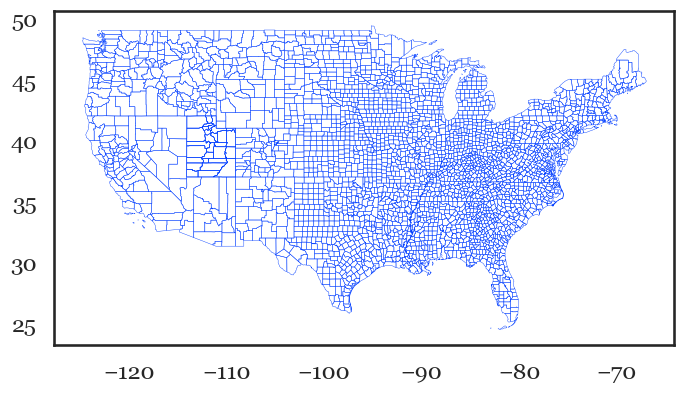

In [12]:
data.boundary.plot(figsize=(8,10), linewidth=0.3);

In [13]:
g_y = data['totalvotes'].values.reshape((-1,1))
g_X = data[[
    'pct_black','pct_hisp','pct_65_over','pct_age_18_29',
            'pct_fb', 'pct_uninsured', 'pct_bach', 'ln_pop_den'
            ]].values

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

u = data["lon"]
v = data["lat"]

g_coords = list(zip(u,v))

##### Calibrate a GWR

In [14]:
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()
print('Bandwidth is:', gwr_bw)
print('=======================')
print('Resid SS is:', gwr_results.resid_ss)
print('=======================')
print('ENP is:', gwr_results.ENP)
print('=======================')
print('AICc is:', gwr_results.aicc)

# gwr_results.summary()

Bandwidth is: 143.0
Resid SS is: 904.7533722425308
ENP is: 451.3961065192949
AICc is: 6058.043970785431


##### MGWR

In [ ]:
mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
mgwr_bw = mgwr_selector.search()
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
mgwr_results.summary()

# Demo

### Utility 1 

- This utillity of the <i> "svc-viz"</i>
tool takes as input a GWR/MGWR model object and generates coefficient surfaces incorporating best visualization practices 

- By default, the tool visualizes all coefficients. The user only needs to specify which coefficient surfaces they want to visualize by passing them as arguments. They can also turn the <i>t</i>-values on or off (by default, t-values are set at the 95% confidence interval but can be adjusted).


- Other kinds of SVC models or Geographically weighted statistic can also be visualized using the `viz_gw` method as shown in utility 2

- Below is an example code with a mgwr model object 

##### User specifying the particular coefficient surface they want to visualize (Figure 3)

In [ ]:
col_names = ['pct_black', 'pct_hisp', 'pct_65_over', 'pct_age_18_29', 'pct_fb', 
    'pct_uninsured', 'pct_bach', 'ln_pop_den']

viz_gwr(
        col_names, 
        data['geometry'], 
        mgwr_results, 
        use_tvalues=True, 
        alpha=0.5, 
        coef_surfaces=['pct_black']
)

##### User decides to see all coefficient surfaces by passing `None` in the `coef_surfaces` argument (Figure 4)

In [ ]:
viz_gwr(
        col_names, 
        data['geometry'], 
        mgwr_results, 
        use_tvalues=True, 
        alpha=0.5, 
        coef_surfaces=None
)

## Utility 2


- The svc-viz tool is not only restricted to GWR/MGWR models but can also be extended to any other SVC model or Geographically Weighted statistic using the `viz_gw` method

- It takes in as argument the original dataframe, the dataframe of the model estimates and their standard errors, and the level of statistical significance for the tvalues. By default, it is set to 0.05

- Using these arguments it generates visualization of all the model coefficients like in utility 1

- Below is an example code for the visualization of a GAM model calibrated with gaussian process splines. The user just needs to pass in to the function the required dataframes

In [ ]:
betas = [col for col in df3.columns if col.startswith('b')]
std_e = [col for col in df3.columns if col.startswith('se')]

viz_gw(
        data['geometry'], 
        df3[betas], 
        df3[std_e], 
        alpha=0.05,
        use_tvalues=True,
        coef_surfaces=None
)

#### Similar to utility 1,  the user specifies what surfaces they want to visualize, following best practices we recommend in the paper

In [ ]:
viz_gw(
        data['geometry'], 
        df3[betas], 
        df3[std_e], 
        alpha=0.05,
        use_tvalues=True,
        coef_surfaces=['beta_bpct_hisp']
)

## Utility 3

- The svc-viz tool can also be used to visualize the coefficients of two SVC models to facilitate the analysis of SVC model replicability across the study area

- This method takes as input: the original dataframe, the dataframe of the model estimates and their standard errors, the name of the coefficient that the user wishes to visualize, and the level of statistical significance for the tvalues of both SVC models. By default, it is set to 0.05

- below is an example using a GWR model and a GAM with Gaussian process splines calibrated on the same dataset. 

In [ ]:
col_names1 = ['pct_black', 'pct_hisp', 'pct_65_over', 'pct_age_18_29', 'pct_fb', 
    'pct_uninsured', 'pct_bach', 'ln_pop_den']

col_names = ['intercept']+col_names1

mgwr_est = pd.DataFrame(mgwr_results.params, columns=col_names)
mgwr_std = pd.DataFrame(mgwr_results.bse, columns=col_names)


betas = [col for col in df3.columns if col.startswith('b')]
std_e = [col for col in df3.columns if col.startswith('se')]


compare_two_surf(data['geometry'], 
                 mgwr_est, 
                 mgwr_std, 
                 df3[betas],
                 df3[std_e], 
                 'beta_pct_bach', 
                 'beta_bpct_bach',
                  use_tvalues=False
)

In [ ]:
compare_two_surf(data['geometry'], 
                 mgwr_est, 
                 mgwr_std, 
                 df3[betas],
                 df3[std_e], 
                 'beta_pct_bach', 
                 'beta_bpct_bach',
                  use_tvalues=True
)

<br />

## Utility 4

- The tool also introduces a novel three-panel visualization, which is essentially a multiview visualization that displays different yet related information about a single variable. It includes the bandwidth and its confidence intervals, a caterpillar plot visualizing the confidence intervals, and finally, the coefficient surface along with its associated uncertainty.


In [ ]:
fits = []
# The tqdm function is called with the iterable that we are looping over, in this case, range(25, len(data))
for i in tqdm(range(100, len(data), 100), desc='Fitting models', unit='model'):
    fits.append(GWR(g_coords, g_y, g_X, i).fit().aicc)

In [ ]:
threePanel(data, col_names1, gwr_results, 
         coef_surfaces=['intercept'], gwr_selector=gwr_selector, aicc=fits)

## Utility 5

- Another novel visualization introduced in the svc-viz tool is a cartographic view that compares how confidence intervals do or do not overlap between two surfaces. 

- This method takes as input: the original dataframe, the dataframe of the model estimates and their standard errors, the name of the coefficient that the user wishes to visualize, and the level of statistical significance for the tvalues of both SVC models. By default, it is set to 0.05

- Below is an example code that plots a map showing locations where the confidence intervals of two svc models overlap and where they do not. Here we use the GWR model and the GAM calibrated with Gaussian process splines on the same datasets

In [ ]:
compare_conf(
    data['geometry'],
    mgwr_est, 
    mgwr_std, 
    df3[betas],
    df3[std_e],
    'pct_bach',
    'bpct_bach',
)

### Reproducible code for Figure 1

In [ ]:
# Load Georgia dataset and generate plot of Georgia counties (figure 1)
georgia_data = pd.read_csv(ps.examples.get_path('GData_utm.csv'))
georgia_shp = gpd.read_file(ps.examples.get_path('G_utm.shp'))

In [ ]:
#Prepare Georgia dataset inputs
g_y = georgia_data['PctBach'].values.reshape((-1,1))
g_X = georgia_data[['PctFB', 'PctBlack', 'PctRural']].values
u = georgia_data['X']
v = georgia_data['Y']
g_coords = list(zip(u,v))

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [ ]:
#Calibrate MGWR model

mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

In [ ]:
#Prepare MGWR results for mapping

#Add MGWR parameters to GeoDataframe
georgia_shp['mgwr_intercept'] = mgwr_results.params[:,0]
georgia_shp['mgwr_fb'] = mgwr_results.params[:,1]
georgia_shp['mgwr_aa'] = mgwr_results.params[:,2]
georgia_shp['mgwr_rural'] = mgwr_results.params[:,3]

#Obtain t-vals filtered based on multiple testing correction
mgwr_filtered_t = mgwr_results.filter_tvals()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Left plot: YlGn colormap
ax0 = axes[0]
ax0.set_title('MGWR Intercept Surface', fontsize=18)

cmap1 = plt.cm.YlGn

mgwr_min = georgia_shp['mgwr_intercept'].min()
mgwr_max = georgia_shp['mgwr_intercept'].max()
vmin, vmax = -0.55, 1  # Keep fixed for both maps

# Adjust colormap
cmap1 = shift_colormap(cmap1, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

# Create scalar mappable for colorbar
sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Plot MGWR parameters (Left)
georgia_shp.plot('mgwr_intercept', cmap=sm1.cmap, ax=ax0, vmin=vmin, vmax=vmax, linewidth=0.4, edgecolor='black', alpha=0.65)

ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

# Right plot: Seismic colormap
ax1 = axes[1]
ax1.set_title('MGWR Intercept Surface', fontsize=18)

cmap2 = plt.cm.seismic

# Adjust colormap
cmap2 = shift_colormap(cmap2, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

# Create scalar mappable for colorbar
sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Plot MGWR parameters (Right)
georgia_shp.plot('mgwr_intercept', cmap=sm2.cmap, ax=ax1, vmin=vmin, vmax=vmax, linewidth=0.4, edgecolor='black', alpha=0.65)

# If there are insignificant parameters, mask them in gray
if (mgwr_filtered_t[:, 0] == 0).any():
    georgia_shp[mgwr_filtered_t[:, 0] == 0].plot(color='lightgrey', ax=ax1, linewidth=0.4, edgecolor='black')

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

# Adjust layout and colorbars
fig.tight_layout()
fig.subplots_adjust(right=0.9)

# Add colorbars for both maps
cax1 = fig.add_axes([0.45, 0.14, 0.01, 0.75])  # Colorbar for left panel
cbar1 = fig.colorbar(sm1, cax=cax1)
cbar1.ax.tick_params(labelsize=15)

cax2 = fig.add_axes([0.92, 0.14, 0.01, 0.75])  # Colorbar for right panel
cbar2 = fig.colorbar(sm2, cax=cax2)
cbar2.ax.tick_params(labelsize=15)

plt.show()


### End Notes

<br/>

--